# 📦 EDA de E-commerce (Olist)

Este notebook organiza a análise com foco em **insights de Marketing**. Estrutura:

1. **Perfil dos clientes e ticket médio por região**  
2. **Produtos/Categorias e faturamento**  
3. **Entrega x Satisfação (atraso vs review)**  
4. **Análise RFM (Recency, Frequency, Monetary)** + **Segmentação**  
5. **Insights e recomendações de Marketing**

# Descrição dos datasets
- **df_customers**: dataset contendo informações sobre os consumidores e sua localização. Colunas:
    - **customer_id** (*UUID*): identifica cada pedido de um consumidor com um id unico.
    - **customer_unique_id** (*UUID*): identifica cada consumidor com um id único.
    - **customer_zip_code_prefix** (*int*): primeiros 5 dígitos CEP da localização de entrega do consumidor.
    - **customer_city** (*str*): cidade do consumidor.
    - **customer_state** (*str*): estado do consumidor.

- **df_orders**: dataset contendo as informações sobre o pedido. Colunas:
    - **order_id** (*UUID*): identifica cada pedido com um código único.
    - **customer_id** (*UUID*): chave que conecta ao dataset **df_costumers** com um id único por pedido.
    - **order_status** (*string*): status do pedido.
    - **order_purchase_timestamp** (*datetime*): data e hora da compra.
    - **order_approved_at** (*datetime*): data e hora de aprovação do pagamento.
    - **order_delivered_carrier_date** (*datetime*): data e hora de postagem da ordem.
    - **order_delivered_customer_date** (*datetime*): data e hora real da entrega ao cliente.
    - **order_estimated_delivery_date** (*datetime*): data e hora estimada de entrega.

- **df_items**: dataset contendo informações sobre os items de cada pedido. Colunas:
    - **order_id** (*UUID*): chave que conecta ao **df_orders** através de um id único por ordem.
    - **order_item_id** (*int*): identifica unicamente cada item dentro de uma ordem.
    - **product_id** (*UUID*): identifica cada produto por meio de um id único.
    - **seller_id** (*UUID*): id único de vendedor.
    - **shipping_limit_date** (*datetime*): data limite para enviar o pedido.
    - **price** (*float*): preço do item.
    - **freight** (*float*): valor do frete do item.

- **df_products**: dataset que contém informações sobre cada produto vendido por Olist. Colunas:
    - **product_id** (*UUID*): id único do produto.
    - **product_category_name** (*string*): nome da categoria a qual o produto pertence.
    - **product_name_length** (*int*): número de caracteres extraídos do nome do produto.
    - **product_description_length** (*int*): número de caracteres extraídos da descrição do produto.
    - **product_photos_qty** (*int*): número de fotos publicadas do produto.
    - **product_weight_g** (*float*): peso do produto medido em gramas.
    - **product_length_cm** (*float*): comprimento do produto medido em centímetros.
    - **product_height_cm** (*float*): altura do produto medida em centímetros.
    - **product_width_cm** (*float*): largura do produto medida em centímetros.

- **df_reviews**: dataset contendo informações sobre os reviews feitas pelos clientes. Colunas:
    - **review_id** (*UUID*): identificador único de cada review.
    - **order_id** (*UUID*): identificador único de cada ordem, conectando ao dataset **df_orders**.
    - **review_score** (*int*): nota variando de 1 a 5 dada pelo cliente em uma pesquisa de satisfação.
    - **review_comment_title** (*string*): título do comentário deixado pelo cliente na review.
    - **review_comment_message** (*string*): mensagem do comentário deixado pelo cliente na review.
    - **review_creation_date** (*datetime*): data em que a pesquisa de satisfação foi enviada ao cliente.
    - **review_answer_timestamp** (*datetime*): data e hora em que foi respondida a pesquisa de satisfação pelo usuário.

- **df_payments**: dataset que contém informações das opções de pagamento dos pedidos. Colunas:
    - **order_id** (*UUID*): identificador único da ordem.
    - **payment_sequential** (*int*): número sequencial que identifica cada método de pagamento utilizado
    por um cliente quando separa o valor em mais de um método de pagamento.
    - **payment_type** (*string*): forma de pagamento utilizada.
    - **payment_installments** (*int*): número de parcelas escolhido pelo cliente.
    - **payment_value** (*float*): valor da transação.

- **df_sellers**: dataset que contém informações sobre vendedores de produtos da Olist. Colunas:
    - **seller_id** (*UUID*): identificador único do vendedor.
    - **seller_zip_code_prefix** (*int*): primeiros 5 dígitos do CEP do vendedor.
    - **seller_city** (*string*): cidade do vendedor.
    - **seller_state** (*string*): estado do vendedor.

- **df_geolocations**: dataset contendo informações de localização sobre CEPs brasileiros. Colunas:
    - **geolocation_zip_code_prefix** (*int*): primeiros 5 dígitos do CEP.
    - **geolocation_lat** (*float*): latitude em que o CEP se encontra.
    - **geolocation_lng** (*float*): longitude em que o CEP se encontra.
    - **geolocation_city** (*string*): nome da cidade a qual o CEP pertence.
    - **geolocation_state** (*string*): sigla do estado que o CEP pertence.

## 1) Perfil dos clientes e ticket médio por região

Métricas básicas e **ticket médio (faturamento / nº de pedidos)** por estado (UF). Isso ajuda a enxergar onde estão os clientes de **alto valor por pedido**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# --------------Leitura dos Datasets-------------------------------------------------------------------------------------------------------------
df_customers = pd.read_csv("data/olist_customers_dataset.csv")
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_items = pd.read_csv("data/olist_order_items_dataset.csv")
df_products = pd.read_csv("data/olist_products_dataset.csv")
df_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_geolocations = pd.read_csv("data/olist_geolocation_dataset.csv")

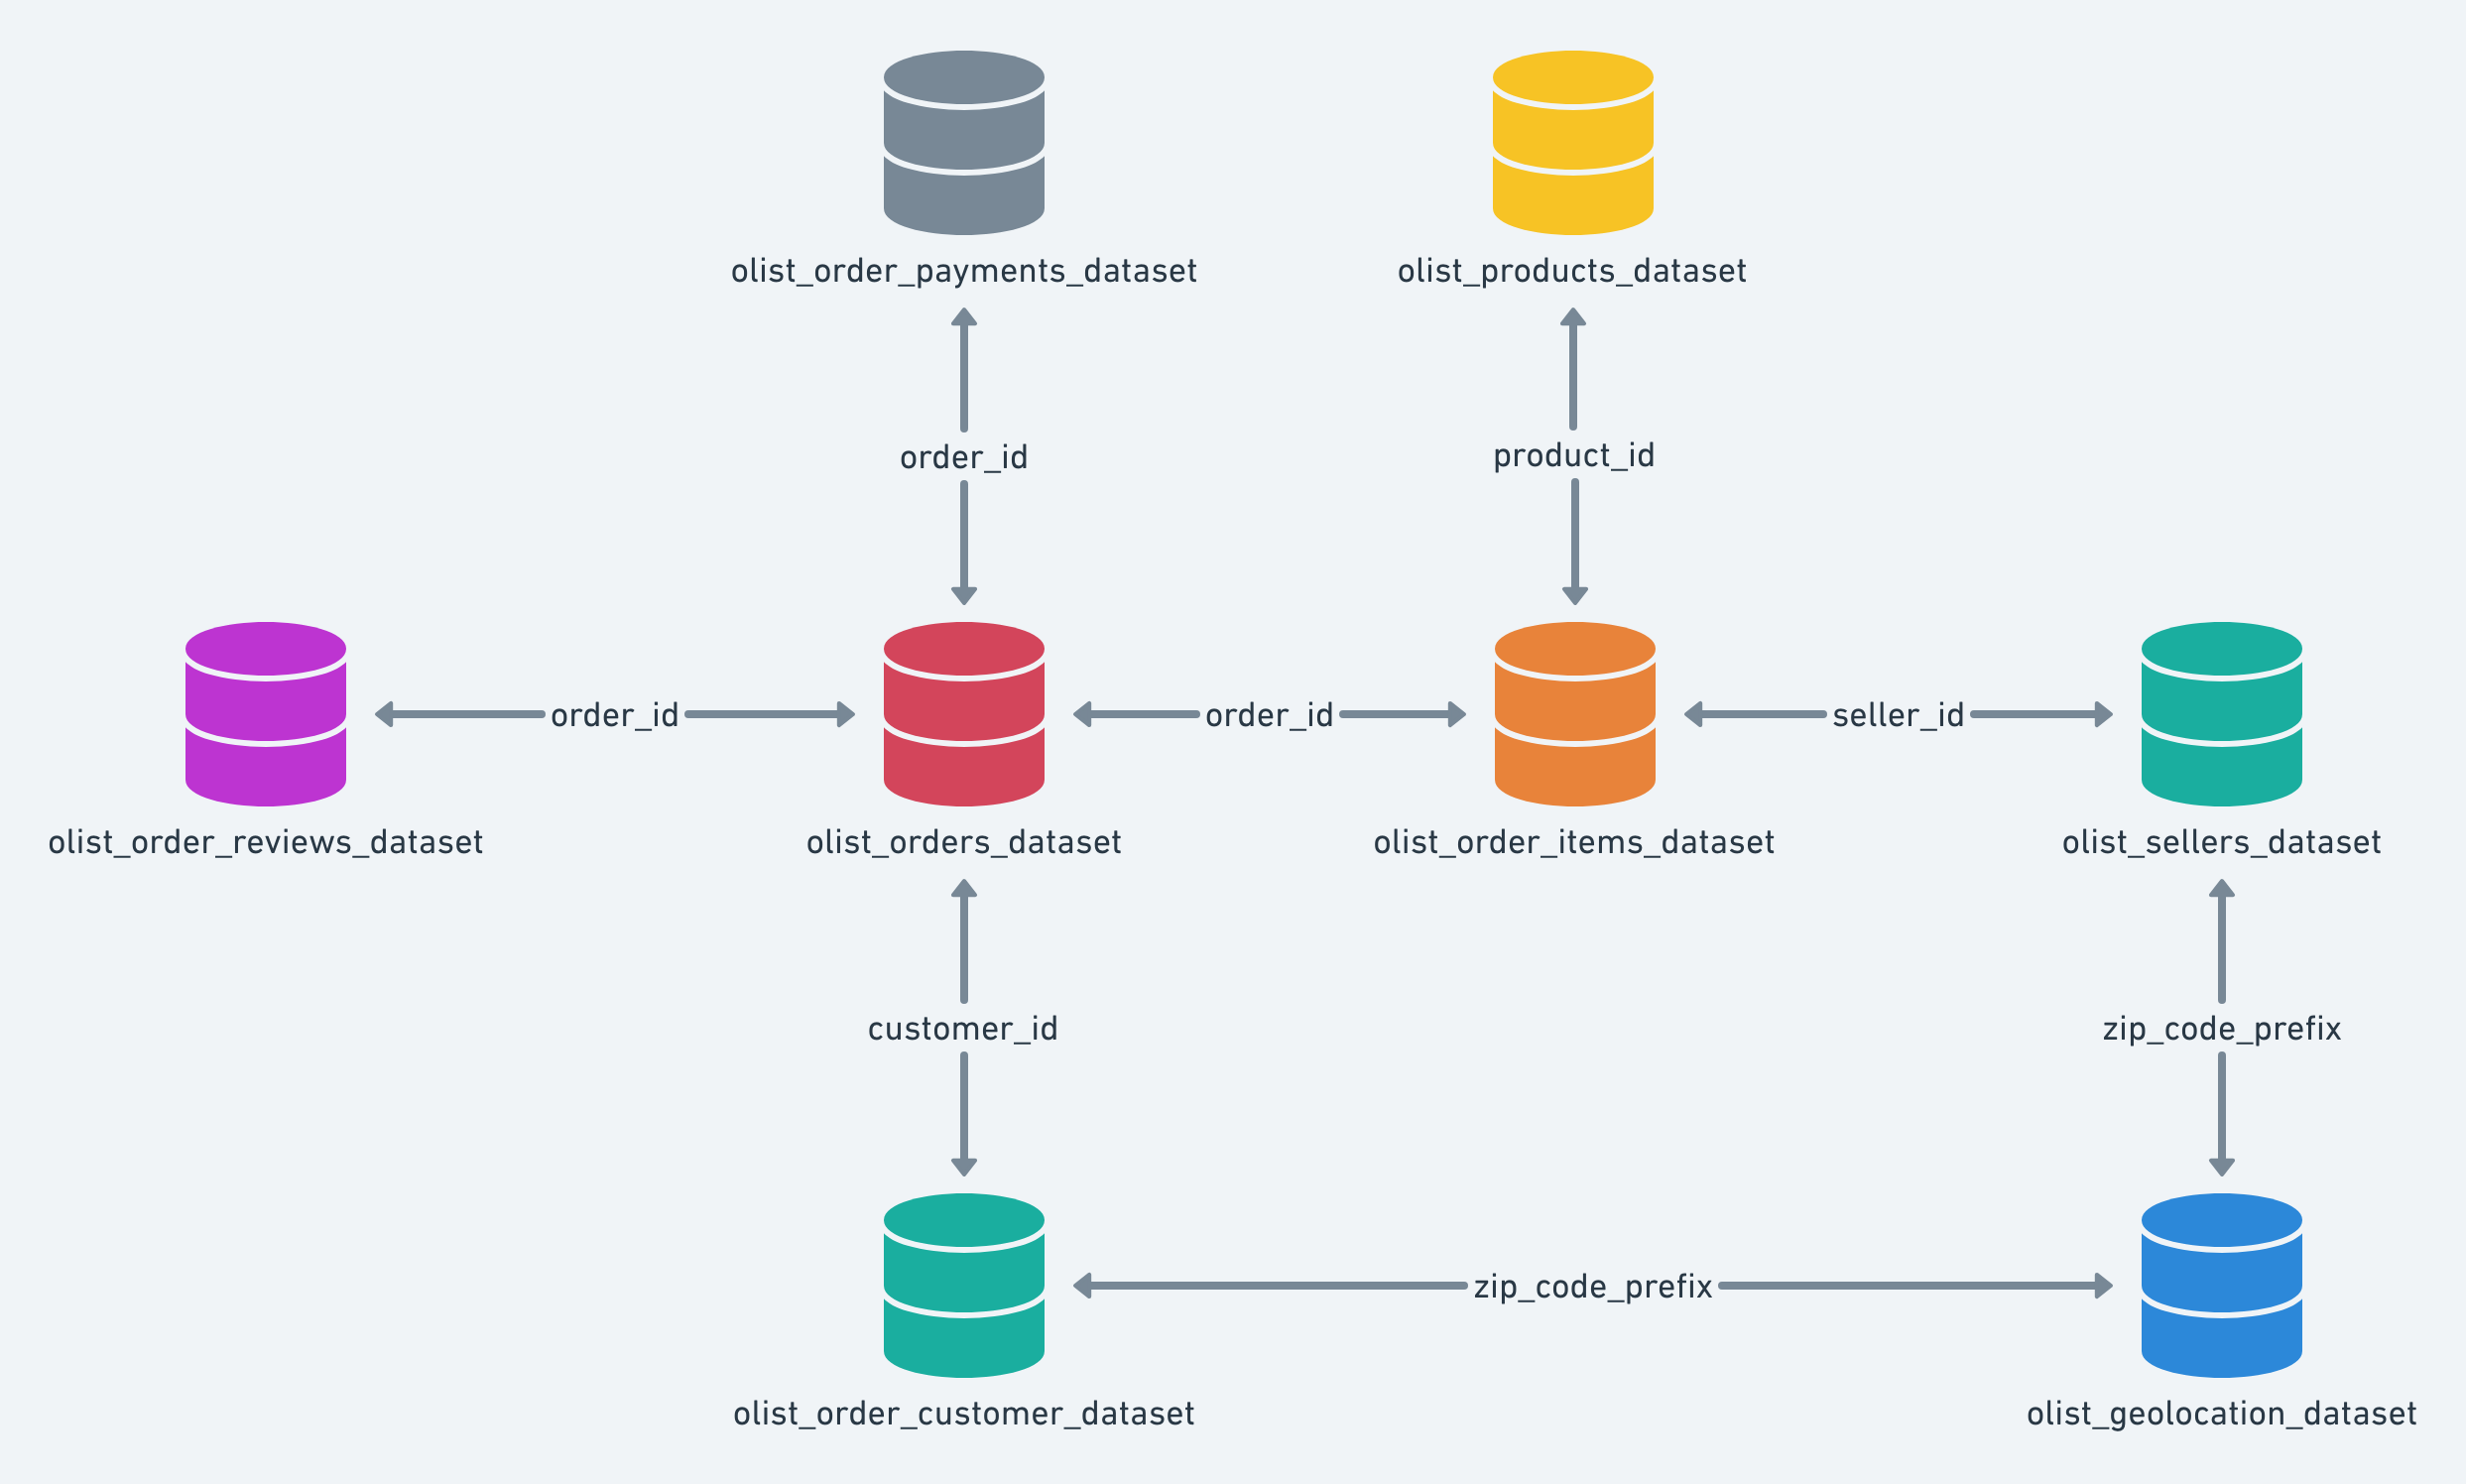

### 1.1) Visualizações Básicas dos Datasets

In [2]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [6]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [8]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [9]:
df_geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### 1.2) Merge dos datasets gerando apenas um

In [10]:

df_geolocations_customers = df_geolocations.rename(columns={
    "geolocation_zip_code_prefix": "customer_zip_code_prefix"
})

df_geolocations_sellers = df_geolocations.rename(columns={
    "geolocation_zip_code_prefix": "seller_zip_code_prefix"
})

geo_agg_customers = (df_geolocations_customers
           .groupby("customer_zip_code_prefix", as_index=False)
           .agg(lat=("geolocation_lat", "mean"),
                lng=("geolocation_lng", "mean")))
geo_agg_sellers = (df_geolocations_sellers
           .groupby("seller_zip_code_prefix", as_index=False)
           .agg(lat=("geolocation_lat", "mean"),
                lng=("geolocation_lng", "mean")))

In [11]:
geo_agg_sellers.head()

,seller_zip_code_prefix,lat,lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [12]:
geo_agg_customers.head()

,customer_zip_code_prefix,lat,lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [13]:
df = (df_orders
           .merge(df_items, on="order_id", how="left")
           .merge(df_customers, on="customer_id", how="left")
           .merge(df_products, on="product_id", how="left")
           .merge(df_reviews, on="order_id", how="left")
           .merge(df_payments, on="order_id", how="left")
           .merge(df_sellers, on="seller_id", how="left")
           .merge(geo_agg_customers, on="customer_zip_code_prefix", how="left")
           .merge(geo_agg_sellers, on="seller_zip_code_prefix", how="left")
        )

In [14]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,lat_x,lng_x,lat_y,lng_y
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,credit_card,1.0,18.12,9350.0,maua,SP,-23.576983,-46.587161,-23.680729,-46.444238
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,voucher,1.0,2.00,9350.0,maua,SP,-23.576983,-46.587161,-23.680729,-46.444238
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,voucher,1.0,18.59,9350.0,maua,SP,-23.576983,-46.587161,-23.680729,-46.444238
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,boleto,1.0,141.46,31570.0,belo horizonte,SP,-12.177924,-44.660711,-19.807681,-43.980427
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,credit_card,3.0,179.12,14840.0,guariba,SP,-16.745150,-48.514783,-21.363502,-48.229601


In [15]:
df['region'] = df['customer_state'].map({
    'SP': 'Sudeste',
    'RJ': 'Sudeste',
    'MG': 'Sudeste',
    'ES': 'Sudeste',
    'RS': 'Sul',
    'PR': 'Sul',
    'SC': 'Sul',
    'BA': 'Nordeste',
    'PE': 'Nordeste',
    'CE': 'Nordeste',
    'MA': 'Nordeste',
    'AL': 'Nordeste',
    'PB': 'Nordeste',
    'SE': 'Nordeste',
    'PI': 'Nordeste',
    'RN': 'Nordeste',
    'GO': 'Centro-oeste',
    'MT': 'Centro-oeste',
    'DF': 'Centro-oeste',
    'MS': 'Centro-oeste',
    'PA': 'Norte',
    'RO': 'Norte',
    'TO': 'Norte',
    'AC': 'Norte',
    'AM': 'Norte',
    'AP': 'Norte',
    'RR': 'Norte'
})

df['region'].head()

0         Sudeste
1         Sudeste
2         Sudeste
3        Nordeste
4    Centro-oeste
Name: region, dtype: object

### 1.3) Perfil dos Clientes

In [16]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'lat_x', 'lng_x', 'lat_y', 'lng_y',
       'region'],
      dtype='object')

In [17]:
# Número de clientes por estado
df_not_cancelled_orders = df[df.order_status != 'canceled']
df_state_count = df_not_cancelled_orders[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index().sort_values(by='customer_unique_id', ascending=False)
df_state_count = df_state_count.rename(columns={'customer_unique_id': 'customer_number'})
df_state_count.head(10)

,customer_state,customer_number
25,SP,49863
18,RJ,15422
10,MG,13744
22,RS,6540
17,PR,6014
23,SC,4324
4,BA,4074
6,DF,2505
8,GO,2451
7,ES,2348


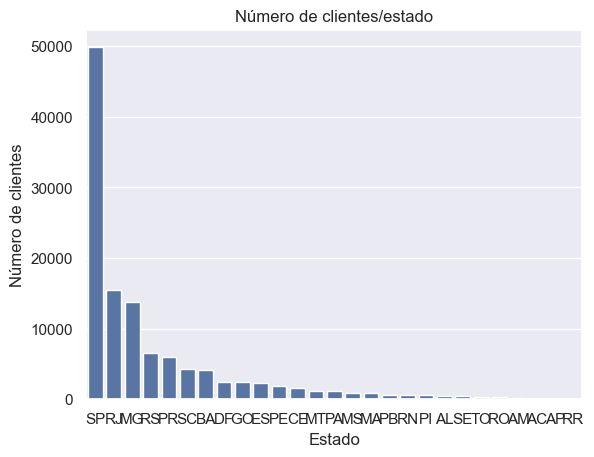

In [18]:
sns.set_theme(style="darkgrid")

sns.barplot(df_state_count, x='customer_state', y='customer_number')
plt.title('Número de clientes/estado')
plt.xlabel('Estado')
plt.ylabel('Número de clientes')
plt.show()

In [19]:
#----------------------------------------------------------------------Comportamento de compra--------------------------------------------------------------------------------------------------------------------------
mean = df_not_cancelled_orders[['customer_unique_id', 'order_id']].groupby('customer_unique_id').count().mean()['order_id']
print(f'Número de compras médio por cliente: {mean:.2f}')

Número de compras médio por cliente: 1.24


### 1.4) Ticket médio por região

In [20]:
# Ticket médio por região
df_region_ticket = df_not_cancelled_orders[['region', 'payment_value']].groupby('region').mean().reset_index().sort_values(by='payment_value', ascending=False).rename(columns={'payment_value': 'average_ticket'})
df_region_ticket

,region,average_ticket
2,Norte,230.215371
1,Nordeste,214.131286
0,Centro-oeste,196.368038
4,Sul,177.423492
3,Sudeste,161.889161


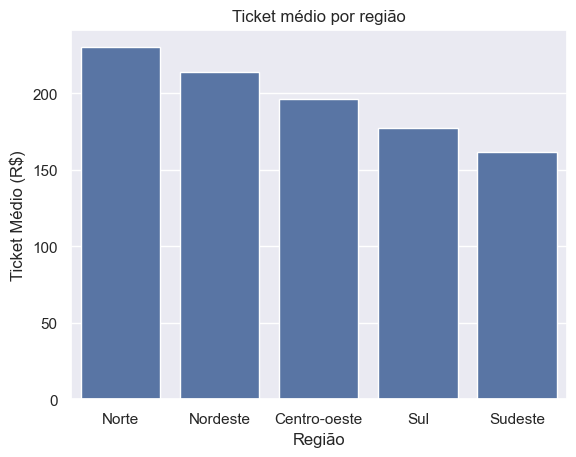

In [21]:
sns.barplot(df_region_ticket, x='region', y='average_ticket')
plt.title('Ticket médio por região')
plt.xlabel('Região')
plt.ylabel('Ticket Médio (R$)')
plt.show()

,customer_state,faturamento_total,pedidos,ticket_medio
14,PB,141545.72,536,264.077836
0,AC,19680.62,81,242.970617
20,RO,60866.20,253,240.577866
3,AP,16262.80,68,239.158824
1,AL,96962.06,413,234.774964
13,PA,218295.85,975,223.893179
26,TO,61485.33,280,219.590464
16,PI,108523.97,495,219.240343
21,RR,10064.62,46,218.796087
24,SE,75246.25,350,214.989286


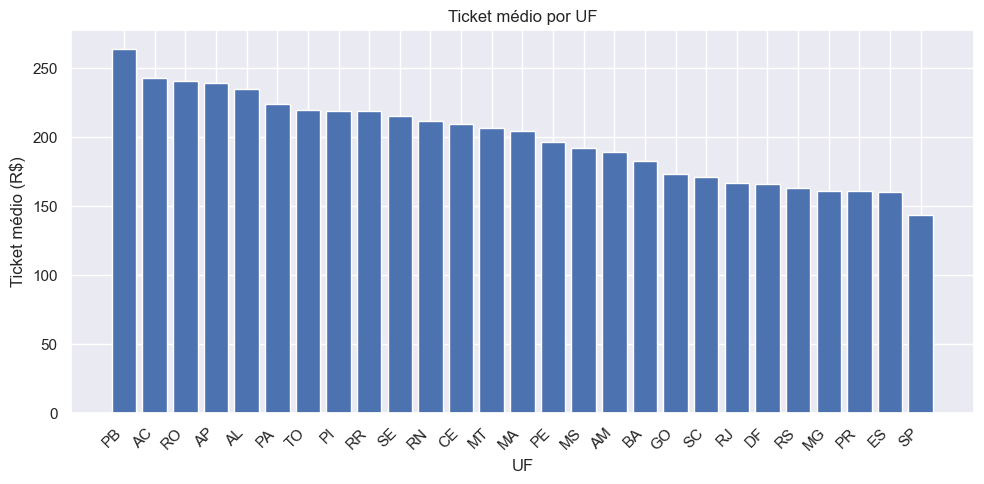

In [22]:
df_orders_pay = df_orders.merge(df_payments, on="order_id", how="left")
df_orders_pay = df_orders_pay.merge(df_customers, on="customer_id", how="left")

df_orders_pay["order_purchase_timestamp"] = pd.to_datetime(df_orders_pay["order_purchase_timestamp"], errors="coerce")

# Valor total pago por pedido
order_totals = (df_orders_pay
                .groupby(["order_id","customer_unique_id","customer_state"], as_index=False)
                .agg(order_purchase_timestamp=("order_purchase_timestamp","max"),
                     payment_value=("payment_value","sum")))

# Ticket médio por estado
ticket_por_estado = (order_totals
                     .groupby("customer_state", as_index=False)
                     .agg(faturamento_total=("payment_value","sum"),
                          pedidos=("order_id","nunique")))
ticket_por_estado["ticket_medio"] = ticket_por_estado["faturamento_total"] / ticket_por_estado["pedidos"]
ticket_por_estado = ticket_por_estado.sort_values("ticket_medio", ascending=False)

display(ticket_por_estado.head(10))

plt.figure(figsize=(10,5))
plt.bar(ticket_por_estado["customer_state"], ticket_por_estado["ticket_medio"]) 
plt.title("Ticket médio por UF")
plt.xlabel("UF")
plt.ylabel("Ticket médio (R$)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 1.5) Tempo médio entre dois pedidos

In [23]:
# Tempo médio entre pedidos
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df_purchase = df[['order_id', 'order_purchase_timestamp']].groupby('order_id').mean().reset_index().sort_values(by='order_purchase_timestamp')
df_purchase

,order_id,order_purchase_timestamp
17931,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19
89489,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05 00:15:34
49869,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13 15:24:19
74448,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38
43966,71303d7e93b399f5bcd537d124c0bcfa,2016-10-02 22:07:52
...,...,...
22190,392ed9afd714e3c74767d0c4d3e3f477,2018-09-29 09:13:03
37735,616fa7d4871b87832197b2a137a115d2,2018-10-01 15:30:09
62892,a2ac6dad85cf8af5b0afb510a240fe8c,2018-10-03 18:55:29
68317,b059ee4de278302d550a3035c4cdb740,2018-10-16 20:16:02


In [24]:
df_purchase['next_order_purchase_timestamp'] = df_purchase['order_purchase_timestamp'].shift(-1)
df_purchase.head()

,order_id,order_purchase_timestamp,next_order_purchase_timestamp
17931,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,2016-09-05 00:15:34
89489,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05 00:15:34,2016-09-13 15:24:19
49869,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13 15:24:19,2016-09-15 12:16:38
74448,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,2016-10-02 22:07:52
43966,71303d7e93b399f5bcd537d124c0bcfa,2016-10-02 22:07:52,2016-10-03 09:44:50


In [25]:
df_purchase['diff_timestamp'] = df_purchase['next_order_purchase_timestamp'] - df_purchase['order_purchase_timestamp']
df_purchase['diff_timestamp'].fillna(df_purchase['diff_timestamp'].mean())
df_purchase.head()

,order_id,order_purchase_timestamp,next_order_purchase_timestamp,diff_timestamp
17931,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,2016-09-05 00:15:34,0 days 03:00:15
89489,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05 00:15:34,2016-09-13 15:24:19,8 days 15:08:45
49869,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13 15:24:19,2016-09-15 12:16:38,1 days 20:52:19
74448,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,2016-10-02 22:07:52,17 days 09:51:14
43966,71303d7e93b399f5bcd537d124c0bcfa,2016-10-02 22:07:52,2016-10-03 09:44:50,0 days 11:36:58


In [26]:
print(f"Tempo médio entre os pedidos: {df_purchase['diff_timestamp'].mean()}")

Tempo médio entre os pedidos: 0 days 00:11:11.497375301


## 2) Produtos/Categorias e faturamento

Além de contar pedidos, é importante olhar **faturamento por categoria** (não só volume). Isso orienta campanhas de **upsell/cross-sell**.


### 2.1) Número de pedidos/categoria

In [27]:
#-----------------------------------------------------Produtos e Categorias-------------------------------------------------------------------------------------------------------------------------------------
df_category_count = df_not_cancelled_orders[['product_category_name', 'order_id']].groupby('product_category_name').count().reset_index().sort_values(by='order_id', ascending=False).rename(columns={'order_id': 'order_count'})
df_category_count.head(10)

,product_category_name,order_count
13,cama_mesa_banho,11970
11,beleza_saude,9992
32,esporte_lazer,8952
54,moveis_decoracao,8794
44,informatica_acessorios,8104
72,utilidades_domesticas,7321
66,relogios_presentes,6192
70,telefonia,4707
40,ferramentas_jardim,4570
8,automotivo,4368


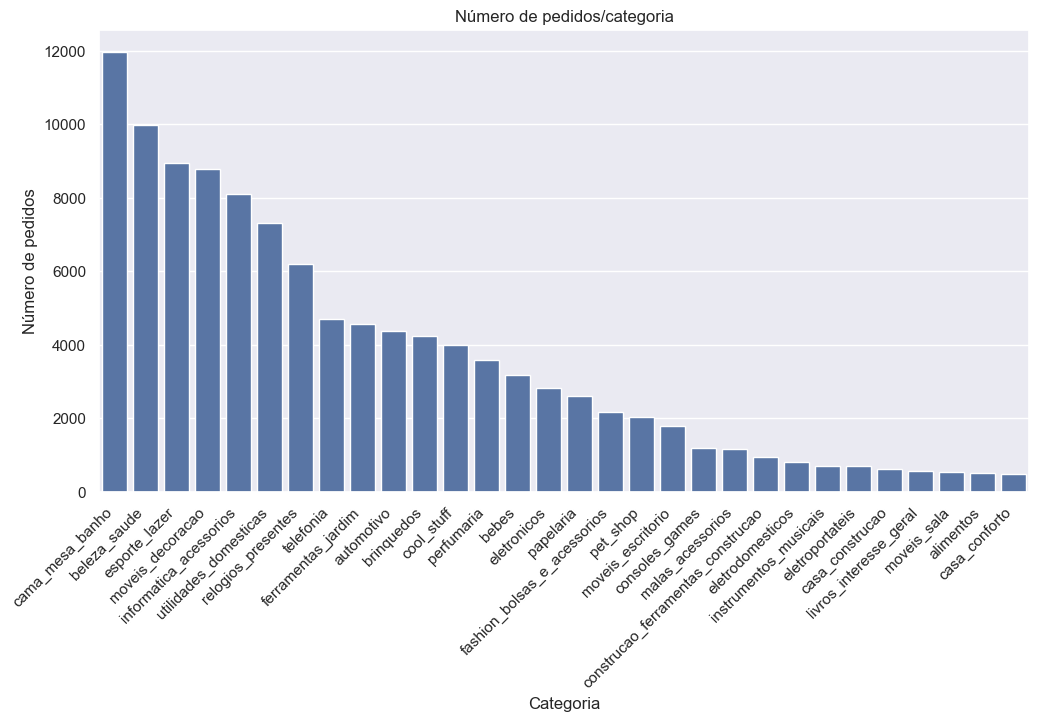

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(df_category_count.head(30), x='product_category_name', y='order_count')
plt.xticks(rotation=45, ha='right')
plt.title('Número de pedidos/categoria')
plt.xlabel('Categoria')
plt.ylabel('Número de pedidos')
plt.show()

### 1.6) Evolução do número de compras ao longo do tempo

In [29]:
cols = ['order_id', 'order_purchase_timestamp']

df[cols[1]] = pd.to_datetime(df['order_purchase_timestamp'])

df_orders_timestamp = df[cols].copy()
df_orders_timestamp.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
2,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49


In [30]:
df_orders_timestamp['order_purchase_month'] = df_orders_timestamp[cols[1]].dt.to_period('M')
df_orders_timestamp.head()

,order_id,order_purchase_timestamp,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10
2,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08


In [31]:
df_orders_timestamp = df_orders_timestamp[['order_id', 'order_purchase_month']].groupby('order_purchase_month').count().reset_index()
df_orders_timestamp.head()

,order_purchase_month,order_id
0,2016-09,7
1,2016-10,401
2,2016-12,1
3,2017-01,1035
4,2017-02,2123


In [32]:
df_orders_timestamp['order_purchase_month'] = df_orders_timestamp['order_purchase_month'].dt.to_timestamp()
df_orders_timestamp.head()


,order_purchase_month,order_id
0,2016-09-01,7
1,2016-10-01,401
2,2016-12-01,1
3,2017-01-01,1035
4,2017-02-01,2123


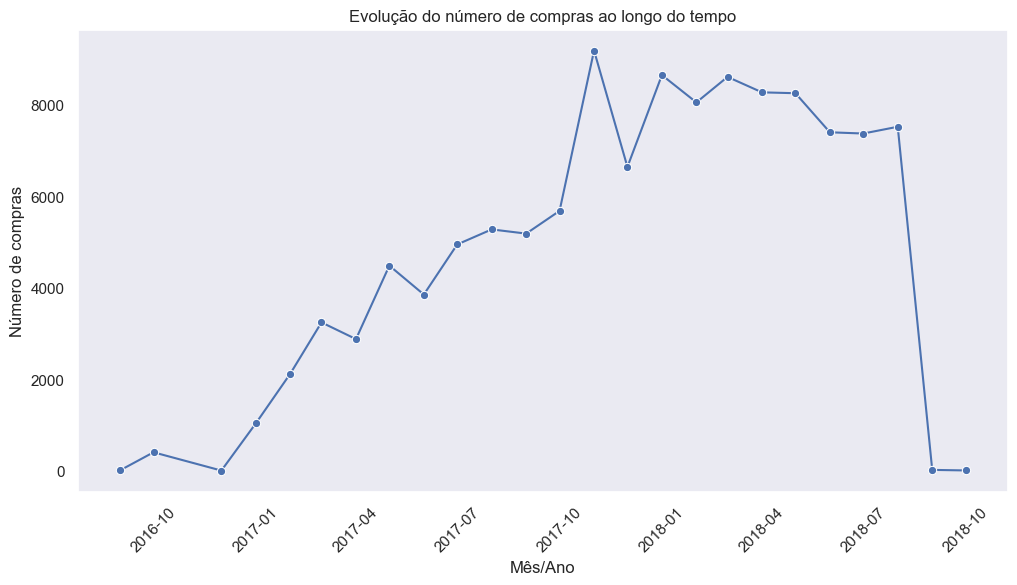

In [33]:
plt.figure(figsize=(12,6))
sns.lineplot(df_orders_timestamp, x='order_purchase_month', y='order_id', marker='o')
plt.xticks(rotation=45)
plt.title('Evolução do número de compras ao longo do tempo')
plt.xlabel('Mês/Ano')
plt.ylabel('Número de compras')
plt.grid()
plt.show()

### 2.2) Ticket médio por categoria

In [34]:
df_category_ticket = df_not_cancelled_orders[['product_category_name', 'payment_value']].groupby('product_category_name').mean().reset_index().sort_values(by='payment_value', ascending=False).rename(columns={'payment_value': 'average_ticket'})
df_category_ticket.head(10)

,product_category_name,average_ticket
61,pcs,1268.734318
71,telefonia_fixa,765.911530
64,portateis_casa_forno_e_cafe,656.786154
0,agro_industria_e_comercio,471.153214
29,eletrodomesticos_2,456.942022
55,moveis_escritorio,364.609328
68,sinalizacao_e_seguranca,340.736567
45,instrumentos_musicais,323.028658
31,eletroportateis,320.967590
25,construcao_ferramentas_seguranca,318.807423


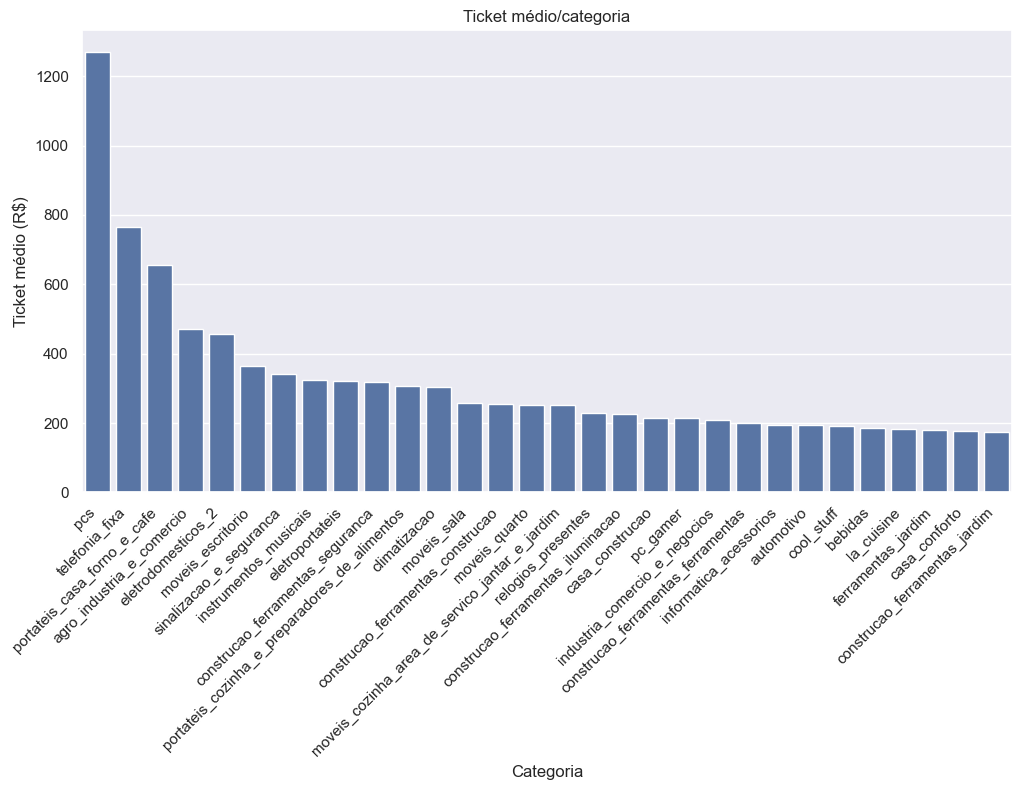

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(df_category_ticket.head(30), x='product_category_name', y='average_ticket')
plt.xticks(rotation=45, ha='right')
plt.title('Ticket médio/categoria')
plt.xlabel('Categoria')
plt.ylabel('Ticket médio (R$)')
plt.show()

In [36]:
top_30_cat_count = df_category_count.head(30).reset_index()
top_30_cat_count

,index,product_category_name,order_count
0,13,cama_mesa_banho,11970
1,11,beleza_saude,9992
2,32,esporte_lazer,8952
3,54,moveis_decoracao,8794
4,44,informatica_acessorios,8104
5,72,utilidades_domesticas,7321
6,66,relogios_presentes,6192
7,70,telefonia,4707
8,40,ferramentas_jardim,4570
9,8,automotivo,4368


In [37]:
df_cat_count_ticket = df_category_count.rename(columns={'order_id': 'order_count'}).merge(df_category_ticket.rename(columns={'payment_value': 'average_ticket'}), on='product_category_name').reset_index()
df_cat_count_ticket.head()

,index,product_category_name,order_count,average_ticket
0,0,cama_mesa_banho,11970,145.589241
1,1,beleza_saude,9992,166.114818
2,2,esporte_lazer,8952,155.212102
3,3,moveis_decoracao,8794,163.574452
4,4,informatica_acessorios,8104,195.668117


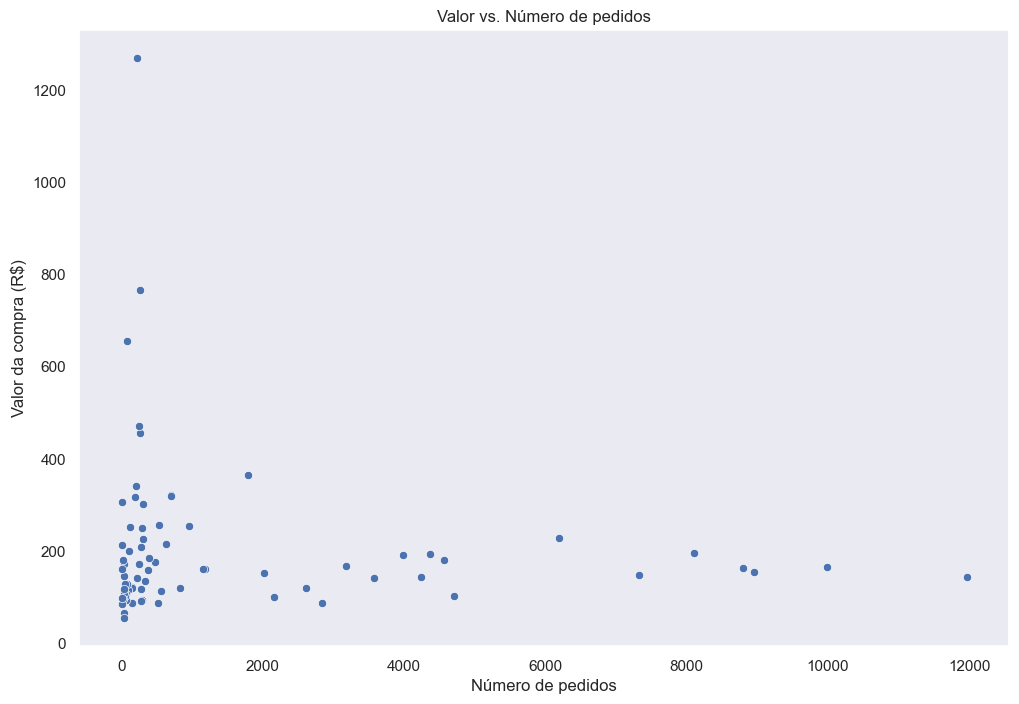

In [38]:
plt.figure(figsize=(12, 8))
sns.scatterplot(df_cat_count_ticket, x='order_count', y='average_ticket')
plt.title('Valor vs. Número de pedidos')
plt.xlabel('Número de pedidos')
plt.ylabel('Valor da compra (R$)')
plt.grid()
plt.show()

### 2.3) Faturamento por categoria

,product_category_name,faturamento,pedidos
11,beleza_saude,1441248.07,8836
66,relogios_presentes,1305541.61,5624
13,cama_mesa_banho,1241681.72,9417
32,esporte_lazer,1156656.48,7720
44,informatica_acessorios,1059272.40,6689
54,moveis_decoracao,902511.79,6449
72,utilidades_domesticas,778397.77,5884
26,cool_stuff,719329.95,3632
8,automotivo,685384.32,3897
40,ferramentas_jardim,584219.21,3518


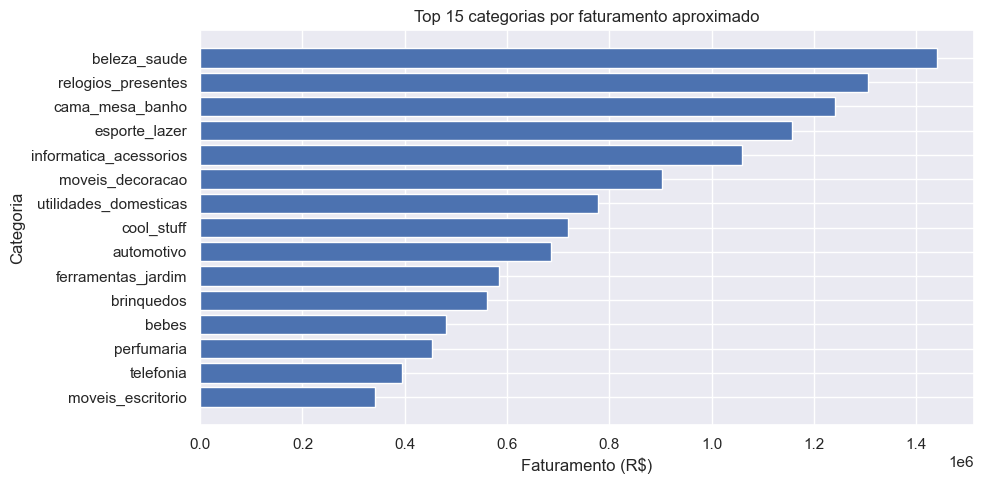

In [39]:
df_items_prod = df_items.merge(df_products, on="product_id", how="left")

# Faturamento por item = price + freight_value (aprox do valor movimentado)
df_items_prod["revenue_item"] = df_items_prod["price"].fillna(0) + df_items_prod["freight_value"].fillna(0)

fat_cat = (df_items_prod
           .groupby("product_category_name", as_index=False)
           .agg(faturamento=("revenue_item","sum"),
                pedidos=("order_id","nunique")))
fat_cat = fat_cat.sort_values("faturamento", ascending=False)

display(fat_cat.head(15))

# Plot faturamento top 15 categorias
top15 = fat_cat.head(15)
plt.figure(figsize=(10,5))
plt.barh(top15["product_category_name"], top15["faturamento"]) 
plt.title("Top 15 categorias por faturamento aproximado")
plt.xlabel("Faturamento (R$)")
plt.ylabel("Categoria")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 3) Entrega x Satisfação (Atraso vs Review)

A satisfação (nota de review) costuma depender fortemente de **atraso de entrega**. Vamos estimar o atraso em dias e verificar sua relação com as notas.


### 3.1) Análise Atraso vs Review score

In [40]:
date_cols = ['order_delivered_customer_date', 'order_estimated_delivery_date']
cols = ['delay', 'review_score']

,review_score,delay_medio,qtd
0,1.0,-4.060580,9409
1,2.0,-8.634818,2941
2,3.0,-10.774052,7962
3,4.0,-12.380840,18987
4,5.0,-13.388153,57060


/tmp/ipykernel_532945/2281843488.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[int(s) for s in scores], showfliers=False)


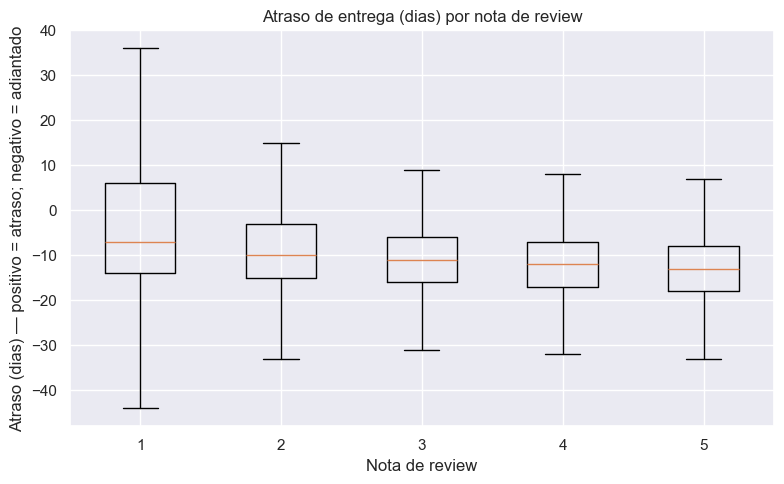

In [41]:
# Datas de entrega na tabela de pedidos
df_orders_dates = df_orders[["order_id","order_delivered_customer_date","order_estimated_delivery_date"]].copy()
df_orders_dates["order_delivered_customer_date"] = pd.to_datetime(df_orders_dates["order_delivered_customer_date"], errors="coerce")
df_orders_dates["order_estimated_delivery_date"] = pd.to_datetime(df_orders_dates["order_estimated_delivery_date"], errors="coerce")

# Atraso (dias): entregue - estimado (positivo = atraso)
df_orders_dates["delivery_delay_days"] = (df_orders_dates["order_delivered_customer_date"] - 
                                          df_orders_dates["order_estimated_delivery_date"]).dt.days

# Juntar com reviews
df_rev = df_reviews[["order_id","review_score"]].copy()
df_rev["review_score"] = pd.to_numeric(df_rev["review_score"], errors="coerce")

df_delay_review = df_orders_dates.merge(df_rev, on="order_id", how="left")

# Relação atraso x nota
rel = (df_delay_review
       .dropna(subset=["review_score","delivery_delay_days"]) 
       .groupby("review_score", as_index=False)
       .agg(delay_medio=("delivery_delay_days","mean"),
            qtd=("order_id","count")))

display(rel.sort_values("review_score"))

# Boxplot simples do atraso por nota
plt.figure(figsize=(8,5))
# preparar dados por score
scores = sorted(df_delay_review["review_score"].dropna().unique())
data = [df_delay_review.loc[df_delay_review["review_score"]==s, "delivery_delay_days"].dropna() for s in scores]
plt.boxplot(data, labels=[int(s) for s in scores], showfliers=False)
plt.title("Atraso de entrega (dias) por nota de review")
plt.xlabel("Nota de review")
plt.ylabel("Atraso (dias) — positivo = atraso; negativo = adiantado")
plt.tight_layout()
plt.show()


In [42]:
df['review_score'].head()

0    4.0
1    4.0
2    4.0
3    4.0
4    5.0
Name: review_score, dtype: float64

In [43]:
#---------------------------------------------------------------------Entregas e satisfação---------------------------------------------------------------------------------------------------------------------------------
# Relação: atraso de entrega × nota de review.
fmt = '%Y-%m-%d %H:%M:%S'

for c in date_cols:
    df[c] = pd.to_datetime(df[c], format=fmt, errors='coerce')

df['delay'] = (df[date_cols[0]] - df[date_cols[1]]).dt.floor('D')
df['delay'] = df['delay'].dt.days

In [44]:
df_delay_review = df[cols].copy()
df_delay_review.head()

,delay,review_score
0,-8.0,4.0
1,-8.0,4.0
2,-8.0,4.0
3,-6.0,4.0
4,-18.0,5.0


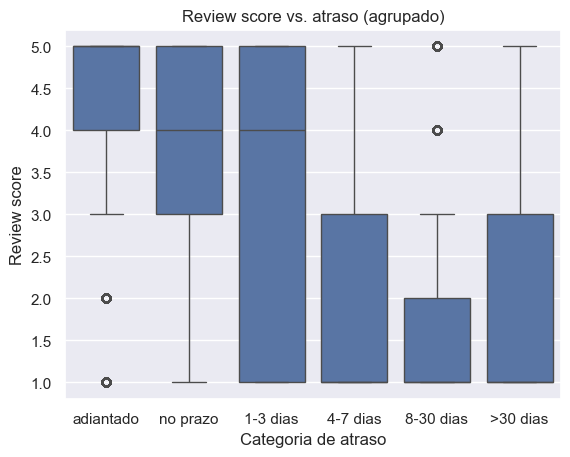

In [45]:
df_delay_review['delay_bucket'] = pd.cut(
    df_delay_review['delay'],
    bins=[-999, -1, 0, 3, 7, 30, 999],
    labels=['adiantado', 'no prazo', '1-3 dias', '4-7 dias', '8-30 dias', '>30 dias']
)

sns.boxplot(data=df_delay_review, x='delay_bucket', y='review_score')
plt.title('Review score vs. atraso (agrupado)')
plt.xlabel('Categoria de atraso')
plt.ylabel('Review score')
plt.show()

In [46]:
df_delay_mean = df_delay_review.groupby('delay')['review_score'].mean().reset_index()

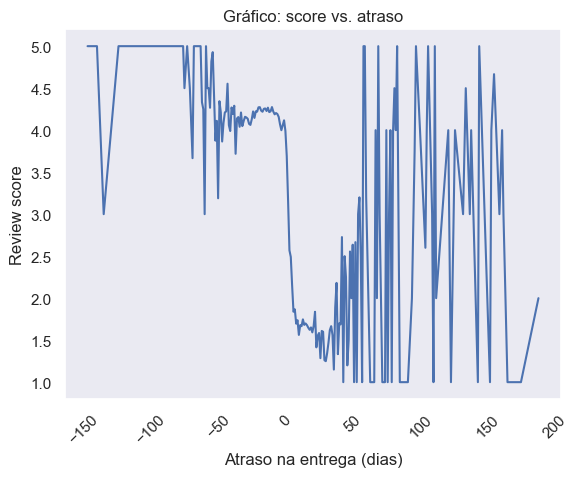

In [47]:
sns.lineplot(df_delay_mean, x='delay', y='review_score')
plt.xticks(rotation=45)
plt.title('Gráfico: score vs. atraso')
plt.xlabel('Atraso na entrega (dias)')
plt.ylabel('Review score')
plt.grid()
plt.show()

### 3.2) Distribuição de atrasos

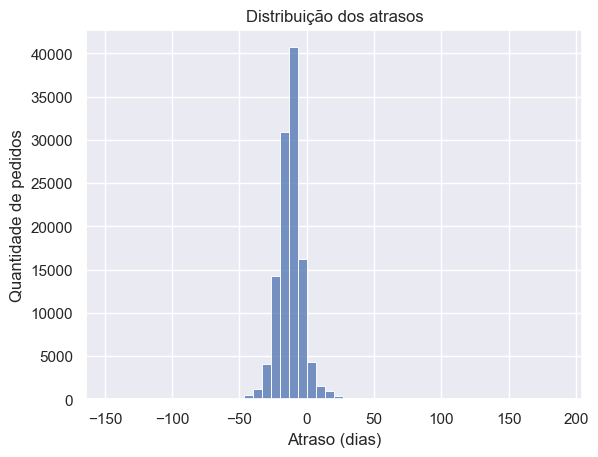

In [48]:
sns.histplot(df_delay_review['delay'], bins=50)
plt.title('Distribuição dos atrasos')
plt.xlabel('Atraso (dias)')
plt.ylabel('Quantidade de pedidos')
plt.show()

### 3.3) Análise da relação entre categoria e atraso

In [49]:
cols = ['product_category_name', 'order_id', 'delay']
df_category_delay = df[cols].copy()
df_category_delay.head()

,product_category_name,order_id,delay
0,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,-8.0
1,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,-8.0
2,utilidades_domesticas,e481f51cbdc54678b7cc49136f2d6af7,-8.0
3,perfumaria,53cdb2fc8bc7dce0b6741e2150273451,-6.0
4,automotivo,47770eb9100c2d0c44946d9cf07ec65d,-18.0


In [50]:
df_cat_delay_count = (
    df_category_delay
    .copy()
    .groupby([cols[0], cols[2]])['order_id']
    .count()
    .reset_index(name='order_count')
)

df_cat_delay_count.head()

,product_category_name,delay,order_count
0,agro_industria_e_comercio,-43.0,15
1,agro_industria_e_comercio,-36.0,1
2,agro_industria_e_comercio,-32.0,1
3,agro_industria_e_comercio,-29.0,2
4,agro_industria_e_comercio,-28.0,2


In [51]:
df_cat_delay_count.shape

(3654, 3)

In [52]:
df_category_count.head(30)

,product_category_name,order_count
13,cama_mesa_banho,11970
11,beleza_saude,9992
32,esporte_lazer,8952
54,moveis_decoracao,8794
44,informatica_acessorios,8104
72,utilidades_domesticas,7321
66,relogios_presentes,6192
70,telefonia,4707
40,ferramentas_jardim,4570
8,automotivo,4368


In [53]:
top_10_categories = df_category_count['product_category_name'].head(10)
df_cat_delay_count_10 = df_cat_delay_count[df_cat_delay_count['product_category_name'].isin(top_10_categories)]
df_cat_delay_count_10.head()

,product_category_name,delay,order_count
302,automotivo,-58.0,2
303,automotivo,-56.0,1
304,automotivo,-52.0,2
305,automotivo,-50.0,1
306,automotivo,-49.0,1


In [54]:
df_category_count.head(10)

,product_category_name,order_count
13,cama_mesa_banho,11970
11,beleza_saude,9992
32,esporte_lazer,8952
54,moveis_decoracao,8794
44,informatica_acessorios,8104
72,utilidades_domesticas,7321
66,relogios_presentes,6192
70,telefonia,4707
40,ferramentas_jardim,4570
8,automotivo,4368


In [55]:
df_cat_delay_count_10 = df_cat_delay_count_10.merge(
    df_category_count.rename(columns={'order_count': 'order_total'}),
    on="product_category_name",
    how="left"
)
df_cat_delay_count_10.head()

,product_category_name,delay,order_count,order_total
0,automotivo,-58.0,2,4368
1,automotivo,-56.0,1,4368
2,automotivo,-52.0,2,4368
3,automotivo,-50.0,1,4368
4,automotivo,-49.0,1,4368


In [56]:
df_cat_delay_count_10["order_freq"] = (
    df_cat_delay_count_10["order_count"] / df_cat_delay_count_10["order_total"]
)

df_cat_delay_count_10.head()

,product_category_name,delay,order_count,order_total,order_freq
0,automotivo,-58.0,2,4368,0.000458
1,automotivo,-56.0,1,4368,0.000229
2,automotivo,-52.0,2,4368,0.000458
3,automotivo,-50.0,1,4368,0.000229
4,automotivo,-49.0,1,4368,0.000229


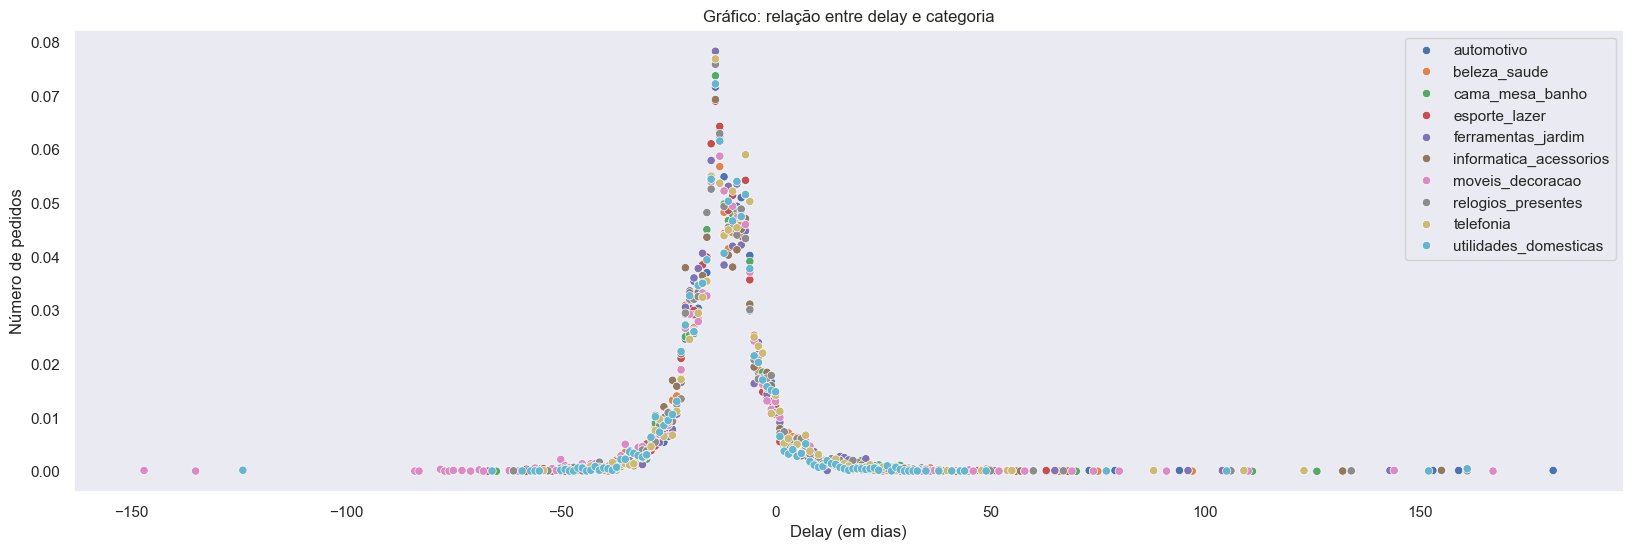

In [57]:
plt.figure(figsize=(20,6))
sns.scatterplot(df_cat_delay_count_10, x='delay', y='order_freq', hue='product_category_name')
plt.legend()
plt.title('Gráfico: relação entre delay e categoria')
plt.xlabel('Delay (em dias)')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid()
plt.show()

### 3.4) Análise dos clientes insatisfeitos

In [58]:
clientes_insatisfeitos = df[df["review_score"] <= 2]
print(clientes_insatisfeitos["customer_unique_id"].nunique(), "clientes insatisfeitos")

14273 clientes insatisfeitos


In [59]:
df_pedidos_clientes = (clientes_insatisfeitos
                        .groupby('customer_unique_id')['order_id']
                        .nunique()
                        .reset_index()
                        .rename(columns={'order_id': 'qtd_pedidos'}))
df_pedidos_clientes.head()

,customer_unique_id,qtd_pedidos
0,00053a61a98854899e70ed204dd4bafe,1
1,0005ef4cd20d2893f0d9fbd94d3c0d97,1
2,000de6019bb59f34c099a907c151d855,1
3,0010a452c6d13139e50b57f19f52e04e,1
4,0012929d977a8d7280bb277c1e5f589d,1


In [60]:
df_clientes_recuperaveis = df_pedidos_clientes[df_pedidos_clientes["qtd_pedidos"] > 1]
print(len(df_clientes_recuperaveis))

249


In [61]:
df_clientes_recuperaveis2 = df_clientes_recuperaveis.merge(df, how='left', on='customer_unique_id')
df_clientes_recuperaveis2["review_comment_message"].dropna().drop_duplicates()

3      Estou aguardando a entrega que era prevista pa...
4      Comprei pela segunda vez e ainda não recebi, p...
7      Solicitei Toner CB436A e recebi Toner CB435A, ...
8      O produto veio com defeito ele não liga não fu...
12     O produto me chegou divergindo em relação ao i...
                             ...                        
886    PRODUTO CHEGOU NA MINHA RESIDÊNCIA TODO QUEBRA...
887    Adquiri o produto através da lannister.com em ...
888    Comprei e paguei um produto em 03/03/2018.\r\n...
903    Fiz a compra de uma cabo para HD externo de 80...
906                                           Nao recebi
Name: review_comment_message, Length: 275, dtype: object

## 4) Análise RFM (Recency, Frequency, Monetary)

A RFM segmenta clientes com base em:
- **Recency (R)**: dias desde a última compra (quanto menor, melhor).
- **Frequency (F)**: nº de pedidos.
- **Monetary (M)**: total gasto.

Geramos **scores de 1 a 5** (quintis) e um **segmento** final orientado a marketing.


,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,4,1,4,9,414,Gastadores recentes
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4,1,1,6,411,Outros
2,0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,4,112,Perdidos
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,4,211,Perdidos
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,7,214,Outros


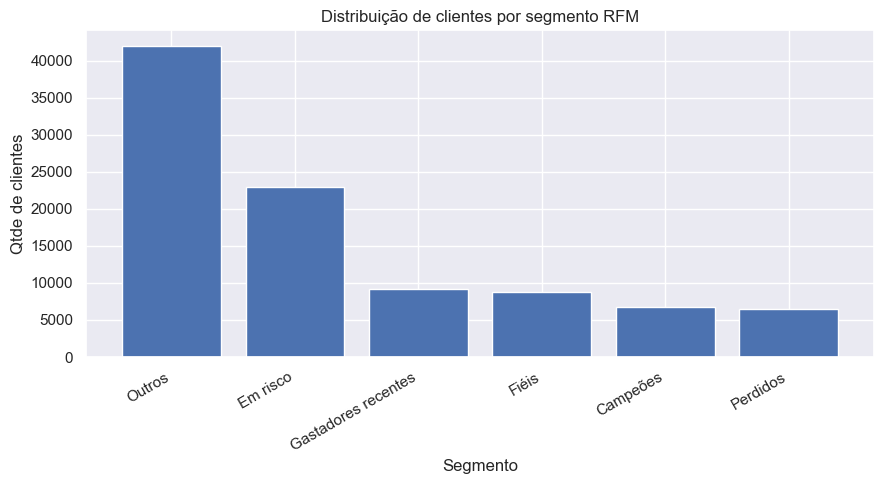

F_Score,1,2,3,4,5
R_Score,,,,,
1,3924,3826,3818,3841,3721
2,3816,3897,3864,3926,3797
3,3760,3767,3816,3891,3809
4,3886,3881,3873,3720,3939
5,3834,3848,3848,3841,3953


In [62]:
from datetime import timedelta
import matplotlib.pyplot as plt

# Reconstruir order_totals se necessário
try:
    order_totals
except NameError:
    df_orders_pay = df_orders.merge(df_payments, on="order_id", how="left")
    df_orders_pay = df_orders_pay.merge(df_customers, on="customer_id", how="left")
    df_orders_pay["order_purchase_timestamp"] = pd.to_datetime(df_orders_pay["order_purchase_timestamp"], errors="coerce")
    order_totals = (df_orders_pay
                    .groupby(["order_id","customer_unique_id"], as_index=False)
                    .agg(order_purchase_timestamp=("order_purchase_timestamp","max"),
                         payment_value=("payment_value","sum")))

ref_date = order_totals["order_purchase_timestamp"].max() + timedelta(days=1)

rfm = (order_totals
       .groupby("customer_unique_id", as_index=False)
       .agg(Recency=("order_purchase_timestamp", lambda x: (ref_date - x.max()).days),
            Frequency=("order_id","nunique"),
            Monetary=("payment_value","sum")))

# Scores (1-5)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)
rfm["RFM_Segment"] = rfm["R_Score"].astype(str)+rfm["F_Score"].astype(str)+rfm["M_Score"].astype(str)

def segment_class(row):
    if row["R_Score"]>=4 and row["F_Score"]>=4 and row["M_Score"]>=4:
        return "Campeões"
    if row["R_Score"]>=4 and row["F_Score"]>=4:
        return "Fiéis"
    if row["R_Score"]>=4 and row["M_Score"]>=4:
        return "Gastadores recentes"
    if row["R_Score"]<=2 and row["F_Score"]>=3:
        return "Em risco"
    if row["R_Score"]<=2 and row["F_Score"]<=2 and row["M_Score"]<=2:
        return "Perdidos"
    return "Outros"

rfm["Segment"] = rfm.apply(segment_class, axis=1)

display(rfm.head())

# Distribuição por segmento
counts = rfm["Segment"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(9,5))
plt.bar(counts.index, counts.values)
plt.title("Distribuição de clientes por segmento RFM")
plt.xlabel("Segmento")
plt.ylabel("Qtde de clientes")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Crosstab R x F
rf_ct = pd.crosstab(rfm["R_Score"], rfm["F_Score"])
display(rf_ct)


In [64]:
import os

output_path = 'outputs'
if not os.path.exists(output_path):
    os.makedirs(output_path)
rfm.to_csv(os.path.join(output_path, 'rfm_table.csv'))

## 5) Insights e recomendações (Auto-gerados)

*Os bullets abaixo são gerados automaticamente a partir das métricas calculadas.*


In [63]:
insights = []

# 1) Top UF por ticket médio
if 'ticket_por_estado' in globals() and not ticket_por_estado.empty:
    top_uf = ticket_por_estado.iloc[0]
    insights.append(f"📍 **Ticket médio mais alto**: {top_uf['customer_state']} (R$ {top_uf['ticket_medio']:.2f}).")
    if len(ticket_por_estado) > 1:
        bot_uf = ticket_por_estado.iloc[-1]
        insights.append(f"↕️ Diferença de ticket médio entre topo e base: R$ {top_uf['ticket_medio']-bot_uf['ticket_medio']:.2f}.")

# 2) Categoria líder de faturamento
if 'fat_cat' in globals() and not fat_cat.empty:
    top_cat = fat_cat.iloc[0]
    insights.append(f"🛍️ **Categoria líder em faturamento**: {top_cat['product_category_name']} (R$ {top_cat['faturamento']:.2f}).")

# 3) Atraso x review
try:
    rel_ok = rel.sort_values('review_score')
    if not rel_ok.empty:
        worst = rel_ok.iloc[0]
        best = rel_ok.iloc[-1]
        insights.append(f"🚚 **Atraso impacta reviews**: Nota {int(worst['review_score'])} tem atraso médio de {worst['delay_medio']:.1f} dias; Nota {int(best['review_score'])} tem {best['delay_medio']:.1f} dias.")
except Exception:
    pass

# 4) Segmentos RFM
if 'rfm' in globals() and not rfm.empty:
    seg_counts = rfm['Segment'].value_counts()
    if not seg_counts.empty:
        principal = seg_counts.index[0]
        insights.append(f"🎯 **Segmento mais numeroso**: {principal} ({seg_counts.iloc[0]} clientes).")
    high_value = rfm.sort_values('Monetary', ascending=False).head(1)
    if not high_value.empty:
        insights.append("💎 **Clientes de alto valor** concentram parcela relevante do faturamento — considerar programa VIP.")

for i in insights:
    print("- " + i)

if not insights:
    print("Nenhum insight automático gerado — verifique se as células anteriores rodaram sem erros.")


- 📍 **Ticket médio mais alto**: PB (R$ 264.08).
- ↕️ Diferença de ticket médio entre topo e base: R$ 120.39.
- 🛍️ **Categoria líder em faturamento**: beleza_saude (R$ 1441248.07).
- 🚚 **Atraso impacta reviews**: Nota 1 tem atraso médio de -4.1 dias; Nota 5 tem -13.4 dias.
- 🎯 **Segmento mais numeroso**: Outros (41977 clientes).
- 💎 **Clientes de alto valor** concentram parcela relevante do faturamento — considerar programa VIP.


- Três estados da Região sudeste (SP, RJ, MG) dominam as vendas. Já os 3 estados da Região Sul ficam logo atrás, mostrando uma concentração de vendas maior na região Centro-Sul. Enquanto isso os estados da Região Norte são os que representam a menor parcela de vendas.
- Em relação ao ticket médio, observamos um maior ticket médio na região Norte e menor no Sudeste, o que, ao relacionarmos com o número de vendas, indica que os clientes da Olist na região Norte realizam compras mais volumosas/caras. Ao mesmo tempo, outra possibilidade é devido ao valor do frete, pois são regiões que possuem um acesso muito mais díficil em relação ao Centro-Sul do país.
- Agora, observando a relação entre atraso e score, podemos ver que em geral, reviews para pedidos com maior atraso tendem a ser mais baixos, mas isso não é regra geral. Portanto, uma das causas de reviews negativos provavelmente é o atraso na entrega, mas não o único.
- Além disso, certas categorias tendem a ter maior atraso em relação às outras, possivelmente devido à maior dificuldade de transportá-las ou outros empecilhos.